In [1]:
import torch
import import_ipynb
from model import UNet3D
from data_loader import BrainTumorDataset

importing Jupyter notebook from model.ipynb
importing Jupyter notebook from data_loader.ipynb


In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"cuDNN version: {torch.backends.cudnn.version()}")

PyTorch version: 2.5.0.dev20240820+cu118
CUDA available: True
cuDNN version: 90100


In [3]:
import torch.nn.functional as F

#refrence: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch

class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

class IoULoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU
    
ALPHA = 0.8
GAMMA = 2
class FocalLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

dice_loss = DiceLoss()
focal_loss = FocalLoss()
iou_score = IoULoss()

    

In [4]:
def load_trained_model(model_path, device):
    model = UNet3D(in_channels=4, num_classes=4)
    model.load_state_dict(torch.load(model_path,weights_only=False))
    model.to(device)
    model.eval()
    return model

In [5]:
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        images, masks = batch
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        dice = dice_loss(outputs, masks)
        focal = focal_loss(outputs, masks)
        loss = dice + focal
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            images, masks = batch
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            
            dice = dice_loss(outputs, masks)
            focal = focal_loss(outputs, masks)
            loss = dice + focal
            
            total_loss += loss.item()
    
    return total_loss / len(dataloader)


In [6]:
from torch.utils.data import DataLoader

#Set up dataset and dataloader
train_img_dir  = '.\BraTS20\BraTS2020_TrainingData\input_data_4channels\\train\images\\'
train_mask_dir  = '.\BraTS20\BraTS2020_TrainingData\input_data_4channels\\train\masks\\'
val_img_dir  = '.\BraTS20\BraTS2020_TrainingData\input_data_4channels\\val\images\\'
val_mask_dir  = '.\BraTS20\BraTS2020_TrainingData\input_data_4channels\\val\masks\\'

train_dataset = BrainTumorDataset(train_img_dir, train_mask_dir)
val_dataset = BrainTumorDataset(val_img_dir, val_mask_dir)

batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


In [7]:
import torch.optim as optim

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = UNet3D(in_channels=4, num_classes=4).to(device)

# #start from saved weights  -- comment this out if you want to train from scratch --
# model_path = 'path to model weights file'
# model= load_trained_model(model_path, device)

LR = 0.0001
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training loop
train_losses = []
val_losses = []
num_epochs = 100

Using device: cuda


In [8]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss = validate(model, val_loader, device)
    print(f'Train Loss: {train_loss:.4f}   |  Val loss : {val_loss:.4f}')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

Epoch 1/100
Starting training epoch...
Starting validation...
Train Loss: 0.8136
Val Loss: 0.8122
Epoch 2/100
Starting training epoch...
Starting validation...
Train Loss: 0.7889
Val Loss: 0.7817
Epoch 3/100
Starting training epoch...
Starting validation...
Train Loss: 0.7668
Val Loss: 0.7603
Epoch 4/100
Starting training epoch...
Starting validation...
Train Loss: 0.7393
Val Loss: 0.7542
Epoch 5/100
Starting training epoch...
Starting validation...
Train Loss: 0.7135
Val Loss: 0.7155
Epoch 6/100
Starting training epoch...
Starting validation...
Train Loss: 0.6950
Val Loss: 0.6901
Epoch 7/100
Starting training epoch...
Starting validation...
Train Loss: 0.6824
Val Loss: 0.6789
Epoch 8/100
Starting training epoch...
Starting validation...
Train Loss: 0.6738
Val Loss: 0.6769
Epoch 9/100
Starting training epoch...
Starting validation...
Train Loss: 0.6673
Val Loss: 0.6860
Epoch 10/100
Starting training epoch...
Starting validation...
Train Loss: 0.6628
Val Loss: 0.6768
Epoch 11/100
Starti

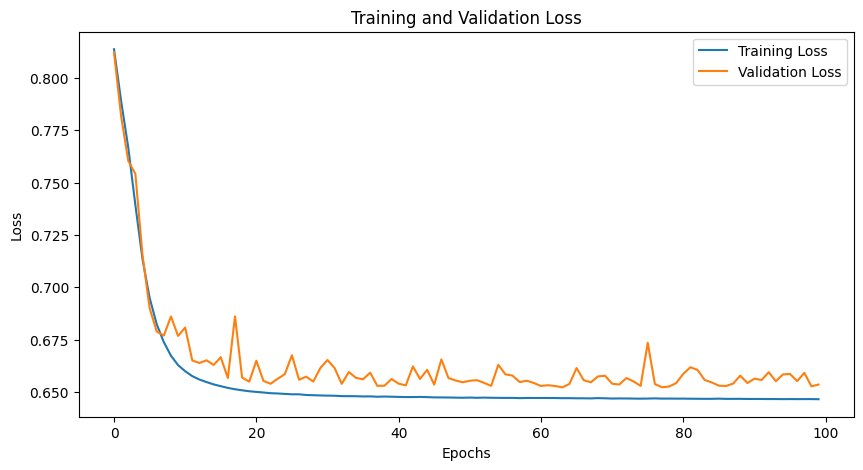

In [9]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
# Save the trained model
torch.save(model.state_dict(), 'trained_3d_unet_for_brain_tumor_segmentation.pth')